In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources

# Ignore all GPUs, tf random forest does not benefit from it.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)





C:\Users\Home\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


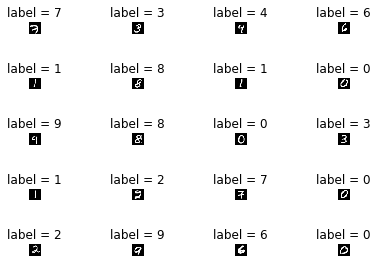

In [2]:
import matplotlib
import matplotlib.pyplot as plt
ROW=5
COLUMN=4
for i in range(ROW * COLUMN):
    # train[i][0] is i-th image data with size 28x28
    image = mnist.train.images[i].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
    plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
    plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
    plt.title('label = {}'.format(mnist.train.labels[i]))
    plt.axis('off')
    
plt.tight_layout()   # automatic padding between subplots
plt.show()


In [3]:

num_steps = 500 # Total steps to train
batch_size = 1024 # The number of samples per batch
num_classes = 10 # The 10 digits
num_features = 784 # Each image is 28x28 pixels
num_trees = 10 #원래는 최소 200에서 시작
max_nodes = 1000 # 보통은 안하는데 feature가 많아서 함

# Input and Target data
X = tf.placeholder(tf.float32, shape=[None, num_features])
# For random forest, labels must be integers (the class id)
Y = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
                                      max_nodes=max_nodes).fill()

# Build the Random Forest
forest_graph = tensor_forest.RandomForestGraphs(hparams)


INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'num_trees': 10, 'max_nodes': 1000, 'bagging_fraction': 1.0, 'feature_bagging_fraction': 1.0, 'num_splits_to_consider': 784, 'max_fertile_nodes': 500, 'split_after_samples': 250, 'min_split_samples': 5, 'valid_leaf_threshold': 1, 'dominate_method': 'bootstrap', 'dominate_fraction': 0.99, 'num_classes': 10, 'num_features': 784, 'bagged_num_features': 784, 'bagged_features': None, 'regression': False, 'num_outputs': 1, 'num_output_columns': 11, 'split_initializations_per_input': 3, 'base_random_seed': 0}


In [4]:
# Get training graph and loss
train_op = forest_graph.training_graph(X, Y) #tree라고 생각하면됨
loss_op = forest_graph.training_loss(X, Y)

# Measure the accuracy
infer_op= forest_graph.inference_graph(X) #train graph와 내부적으로 연결되어있음
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #얘를 낮추는 방향으로 train_op를 튜닝
print(accuracy_op)

INFO:tensorflow:training graph for tree: 0
INFO:tensorflow:training graph for tree: 1
INFO:tensorflow:training graph for tree: 2
INFO:tensorflow:training graph for tree: 3
INFO:tensorflow:training graph for tree: 4
INFO:tensorflow:training graph for tree: 5
INFO:tensorflow:training graph for tree: 6
INFO:tensorflow:training graph for tree: 7
INFO:tensorflow:training graph for tree: 8
INFO:tensorflow:training graph for tree: 9
Tensor("Mean_1:0", shape=(), dtype=float32)


In [5]:

# Initialize the variables (i.e. assign their default value) and forest resources
init_vars = tf.group(tf.global_variables_initializer(),
    resources.initialize_resources(resources.shared_resources()))

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars)

# Training
for i in range(1, num_steps + 1):
    # Prepare Data
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    _, l = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
    if i % 50 == 0 or i == 1:
        acc = sess.run(accuracy_op, feed_dict={X: batch_x, Y: batch_y})
        print('Step %i, Loss: %f, Acc: %f' % (i, l, acc))

# Test Model
test_x, test_y = mnist.test.images, mnist.test.labels
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))

Step 1, Loss: -0.000000, Acc: 0.108398
Step 50, Loss: -121.599998, Acc: 0.828125
Step 100, Loss: -272.399994, Acc: 0.868164
Step 150, Loss: -425.200012, Acc: 0.902344
Step 200, Loss: -585.799988, Acc: 0.904297
Step 250, Loss: -743.000000, Acc: 0.900391
Step 300, Loss: -898.000000, Acc: 0.916992
Step 350, Loss: -998.000000, Acc: 0.931641
Step 400, Loss: -998.000000, Acc: 0.912109
Step 450, Loss: -998.000000, Acc: 0.903320
Step 500, Loss: -998.000000, Acc: 0.918945
Test Accuracy: 0.9182
